In [1]:
import sys
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams
matplotlib.rcdefaults()
plt.rcParams['mathtext.fontset'] = "cm"


%load_ext autoreload
%autoreload 1
sys.path.append("../functions")
%aimport general_functions
%aimport monod
function_derivatives = monod.model_derivatives

#Check Python version
print(sys.version)

3.9.15 (main, Nov 24 2022, 14:39:17) [MSC v.1916 64 bit (AMD64)]


## Monod kinetics ODE system to obtain S and X concentration profiles


$$\frac{dX}{dt}= \mu_{max}\frac{S}{K_{S}+S}X - \frac{Q}{V}X$$

$$\frac{dS}{dt}= -\frac{1}{Y} \mu_{max}\frac{S}{K_{S}+S}X + \frac{Q}{V}(S_{in} - S)$$

We can use the model defined in ```functions/monod```and plot the results with different initial conditions and parameters.

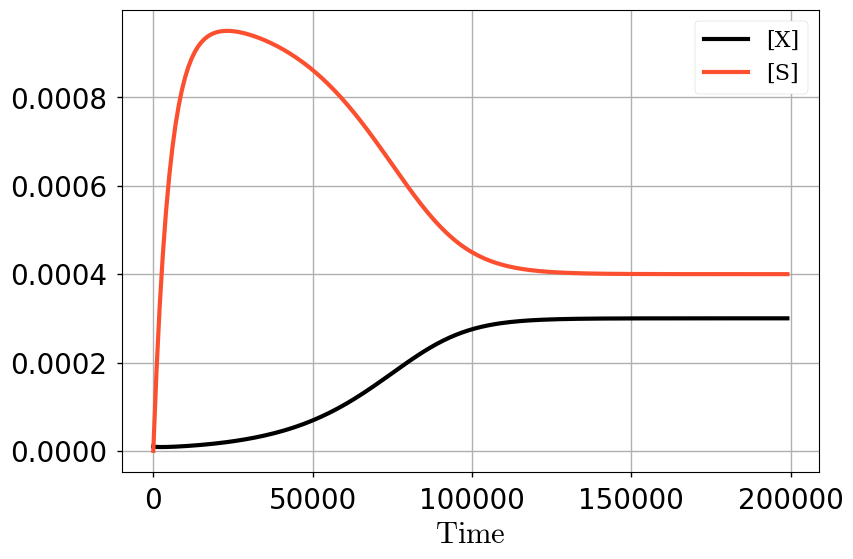

In [2]:
# Initial conditions
X_init = 1e-5
S_init = 0

# Parameters and inlets
K_S = 2e-4
mu_max = 3e-4
Q = 1
V  = 5000
Y = 0.5
S_in = 0.001

df = general_functions.model(
    np.arange(0, 200000, 1000), # Timesteps
    [X_init, S_init], # Initial conditions
    ['[X]','[S]'], # Variable names
    function_derivatives, # Function derivatives
    returnDataFrame=True, plotresults=True,
    # Specify parameter values
    mu_max=mu_max, Q=Q, V=V, Y=Y, K_S=K_S, S_in=S_in)

'''ax = plt.gca()
y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=True)
ax.yaxis.set_major_formatter('{x:.0e}')
ax.xaxis.set_major_formatter('{x:1.2g}')'''

plt.show()

## Monod Kinetic expression

We plot the results of using the Monod model. As ```functions``` folder does not have this function, we can implement it ourselves and plot the results.

In [3]:
# We define the function that should return the specific growth rate directly
def Monod_kinetics(S,mu_max,Ks):
    '''
    S      : Substrate concentration
    mu_max : Maximum specific growth rate
    Ks     : Half-saturation constant
    '''
    return mu_max*(S/(Ks+S))

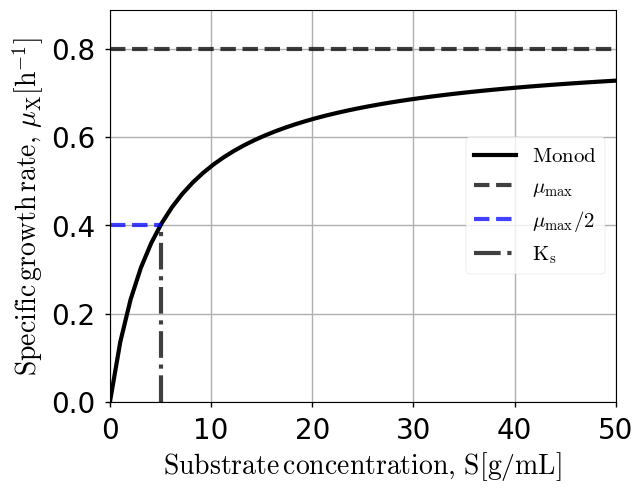

In [4]:
# Parameters for the figure:
mu_max = 0.8 # h^-1
K_s = 5 # mg/L

S = np.linspace(0,50,num=50) #g/L

# We can plot the results of our model using the plotting library matplotlib (named plt)
fig = plt.figure(figsize=(6.5,5))
fig.subplots_adjust(hspace=0.2, wspace = 0.3)
ax1 = fig.add_subplot(111)
ax1.plot(S,Monod_kinetics(S,mu_max,K_s),'k-',label = r'$\mathrm{Monod}$')
ax1.plot([0,np.max(S)],[mu_max,mu_max],'k--',label = r'$\mathrm{\mu_{max}}$',alpha=0.75)
ax1.plot([0,K_s],[mu_max/2,mu_max/2],'b--',label = r'$\mathrm{\mu_{max}/2}$',alpha=0.75)
ax1.plot([K_s,K_s],[0,mu_max/2],'k-.',label = r'$\mathrm{K_s}$',alpha=0.75)
ax1.set_xlim([0,np.max(S)])
ax1.set_ylim([0,mu_max*1.11])
ax1.legend(loc=5,fontsize=15)
ax1.set_xlabel(r'$\mathrm{Substrate\/concentration,\/S[g/mL]}$', fontsize=20)
ax1.set_ylabel(r'$\mathrm{Specific\/growth\/rate,\/\mu_X[h^{-1}]}$', fontsize=20,)
fig.tight_layout(pad=0.4, w_pad=1, h_pad=1.0)
#plt.minorticks_on()

plt.show()

## Implementation of the Bioreactor model using the Monod growth model

We will now implement manually the system of differential equations and compare it to the one that we use when we import ```functions/monod```.

In [6]:
# Python library to solve ODEs (and many more things!)
from scipy.integrate import odeint

# We define our model and we simultaneously solve it
def solve_Monod_model(t,u,mu_max,Y,Ks,Q,V,S_in,init):
    def model(u,t):
        '''
        Differential equation
        '''
        dXdt = Q/V*(-u[0])+mu_max*(u[1]/(Ks+u[1]))*u[0]          #Biomass X
        dSdt = Q/V*(S_in-u[1])-1/Y*mu_max*(u[1]/(Ks+u[1]))*u[0]  #Reactant S

        return [dXdt,dSdt]

    # We solve the system by providing the model, the initial conditions, and the time array
    y=odeint(model,init,t)
    
    return y

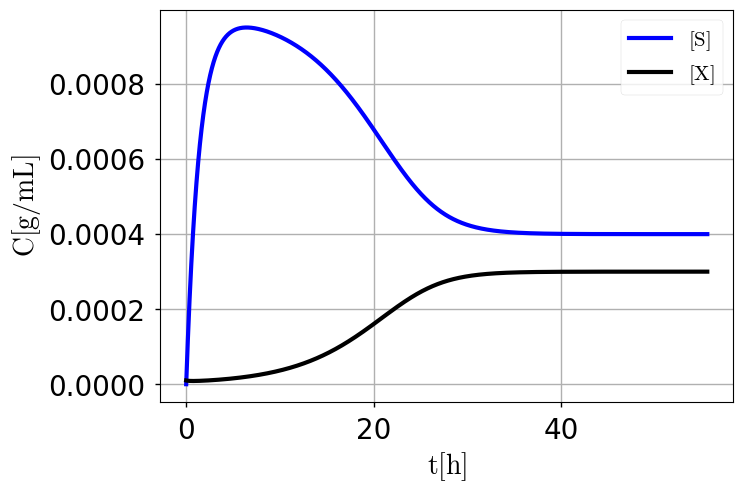

In [7]:
# We provide the variables 
S_in = 0.001
S_init = 0
X_init = 1e-5

# Python list to be provided for the scipy solver
init = [X_init,S_init]

# Parameter values
Ks = 2e-4
mu_max = 3e-4
Q = 1
V  = 5000
Y = 0.5

# We define the time array with the start, final, and time step for the scipy integrator
time = np.arange(0.,200000,10)

# We solve the system
y = solve_Monod_model(time,init,mu_max,Y,Ks,Q,V,S_in,init)

# We store the solution
X = y[:,0]
S = y[:,1]

# We plot the solution
fig = plt.figure(figsize=(7.5,5))
fig.subplots_adjust(hspace=0.2, wspace = 0.3)

ax1 = fig.add_subplot(111)
ax1.plot(time/60/60,S,'b-',label = r'$\mathrm{[S]}$')
ax1.plot(time/60/60,X,'k-',label = r'$\mathrm{[X]}$')

ax1.legend(loc=1,fontsize=15)
ax1.set_ylabel(r'$\mathrm{C[g/mL]}$', fontsize=20)
ax1.set_xlabel(r'$\mathrm{t[h]}$', fontsize=20,rotation=0)
fig.tight_layout(pad=0.4, w_pad=1, h_pad=1.0)
ax1.grid(True)
#plt.minorticks_on()
plt.show()

We observe that the results are just the same

## Linearisation of Monod kinetics around the operating point

We will now manually implement the linearised version of the bioreactor model using Monod kinetis (around the operating point) just like we did before and we will compare the results.

Ifwe substitute in the model the first of the operating points (0,$S_{in}$,$S_{in}$) we get:

$$\frac{dX}{dt} \approx \Big(\mu_{max}\frac{\bar{S}_{in}}{K_{S}+\bar{S}_{in}}X - \frac{Q}{V}\Big)X$$

$$\frac{dS}{dt} \approx -\frac{1}{Y} \mu_{max}\frac{\bar{S}_{in}}{K_{S}+\bar{S}_{in}}X-\frac{Q}{V}(S-\bar{S}_{in})$$

In [8]:
# We implement different derivatives for the linearised version and solve it
def solve_Monod_lin_model(t,u,mu_max,Y,Ks,Q,V,S_in,init):
    def model(u,t):
        '''
        Differential equation
        '''
        dXdt = (mu_max*(S_in/(Ks+S_in))-Q/V)*u[0]#+Ks*mu_max/(Ks+S_in)**2*u[0]*(u[1]-S_in)  #Biomass X
        dSdt = -(mu_max*S_in/(Y*(Ks+S_in)))*u[0]-Q/V*(u[1]-S_in) #- Ks*mu_max/(Y*(Ks+S_in)**2)*u[0]*(u[1]-S_in)  #Reactant S

        return [dXdt,dSdt]
        
    y=odeint(model,init,time)
    return y

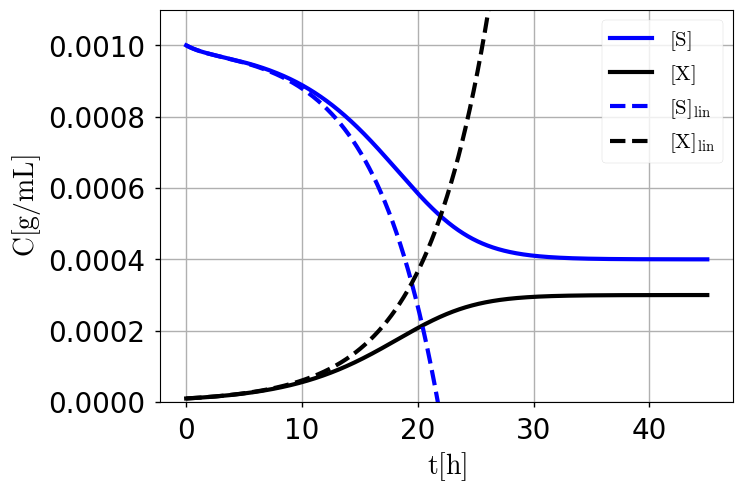

In [28]:
# Parameters, initial conditions, and time array
S_in = 0.001
S_init = 0.001
X_init = 1e-5
init = [X_init,S_init]
Q = 1
V  = 5000
Y = 0.5
Ks = 2e-4
mu_max = 3e-4
t_final = 45
time = np.arange(0.,t_final*60*60,10)

# We solve the correct model
y = solve_Monod_model(time,init,mu_max,Y,Ks,Q,V,S_in,init)
X = y[:,0]
S = y[:,1]

# We solve the linearise version
ylin = solve_Monod_lin_model(time,init,mu_max,Y,Ks,Q,V,S_in,init)
Xlin = ylin[:,0]
Slin = ylin[:,1]

# We plot the results
fig = plt.figure(figsize=(7.5,5))
fig.subplots_adjust(hspace=0.2, wspace = 0.3)

ax1 = fig.add_subplot(111)
ax1.plot(time/60/60,S,'b-',label = r'$\mathrm{[S]}$')
ax1.plot(time/60/60,X,'k-',label = r'$\mathrm{[X]}$')

ax1.plot(time/60/60,Slin,'b--',label = r'$\mathrm{[S]_{lin}}$')
ax1.plot(time/60/60,Xlin,'k--',label = r'$\mathrm{[X]_{lin}}$')

ax1.set_ylim(0,1.10*S_in)
ax1.legend(loc=1,fontsize=15)
ax1.set_ylabel(r'$\mathrm{C[g/mL]}$', fontsize=20)
ax1.set_xlabel(r'$\mathrm{t[h]}$', fontsize=20,rotation=0)
fig.tight_layout(pad=0.4, w_pad=1, h_pad=1.0)
#plt.minorticks_on()

plt.show()